In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import warnings
warnings.filterwarnings('always')

import anndata
import numpy as np
import h5py
import scipy.stats as st
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import torch

from scbasset.utils import *
import scbasset.metrics as metrics
from scbasset.model_class import ModelClass
from scbasset.config import Config

In [16]:
start_directory = '../../../'
# start_directory = ''

type_data = 'TF_to_region'
file_name = 'TF_to_region_hvg'

# file_name = 'TF_to_region_marker_genes'
# file_name = 'TF_to_region_ctx'
# file_name = 'TF_to_region_scplus'
# file_name = 'region_accesibility'

only_tf, motif, rug = (False, True, "rug") if file_name == 'TF_to_region_hvg' else (True, False, None)

data_path = start_directory + 'data/' + type_data + '/processed/'

In [17]:
# os.makedirs("../..", exist_ok=True)
print(torch.cuda.is_available())
device = "cuda"
if "cuda" in device and not torch.cuda.is_available():
    device = "cpu"
else:
    torch.cuda.set_device(2)

print(device)

True
cuda


tfbanformer

In [18]:
seq_len_tfb = 768

ad_file_tfb = data_path + file_name + '-' + str(seq_len_tfb) + '-ad.h5ad'
h5_file_tfb = data_path + file_name + '-' + str(seq_len_tfb) + '-train_val_test.h5'

f = h5py.File(h5_file_tfb, 'r')
X = f['X'][:].astype('float32')
Y = f['Y'][:].astype('float32')

# Split train-validation set
# train_ids, val_ids, test_ids = f['train_ids'][:], f['val_ids'][:], f['test_ids'][:]

X = torch.FloatTensor(X)

n_TFs = Y.shape[1]
ic(n_TFs, Y.shape[0])

ad_tfb = anndata.read_h5ad(ad_file_tfb)
ad_tfb

ic| n_TFs: 945, Y.shape[0]: 12835
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 945 × 12835
    obs: 'TF', 'exp_id', 'cell_line', 'motif_model', 'n_genes'
    var: 'chr', 'start', 'end', 'n_cells'

In [19]:
config = Config()
config.h5_file = h5_file_tfb

config.activation_fct = 'gelu'
config.batch_size = 64
config.num_heads = 8
config.num_transforms = 7
config.tower_multiplier = 1.222

# config.model_name = 'scbasset'
# config.repeat = 6
# config.bottleneck_size = 32

config.model_name = 'tfbanformer'
config.repeat = 4
config.bottleneck_size = 64

print(config)

# load model
dashboard_model = ModelClass(config, n_TFs=n_TFs)
dashboard_model.activate_analysis()
dashboard_model.load_data(h5_file_tfb, shuffle=False)

post_fix = str(config.bottleneck_size) + '_' + str(config.seq_length) + '_' + str(config.repeat)
post_fix = post_fix if config.model_name == 'scbasset' else post_fix + '_' + str(config.num_heads) + '_' + str(config.num_transforms)
post_fix += '_' + str(config.batch_size) + '_' + str(config.activation_fct) + '_' + str(config.tower_multiplier).replace('.', '-')

# post_fix = post_fix + '_TL'

model_path = 'output/' + config.model_name + '/' + file_name + '/' + post_fix + '/'
dashboard_model.load_weights(device, best=1, start_directory=start_directory, trained_model_dir=model_path)

dashboard_model.get_model_summary()
model_tfbanformer = dashboard_model.model
model_tfbanformer.to(device);
model_tfbanformer

Config(parser_args=None, out_dir='output', bottleneck=32, batch_size=64, learning_rate=0.01, epochs=1000, h5_file='../../../data/TF_to_region/processed/TF_to_region_hvg-768-train_val_test.h5', model_name='tfbanformer', residual_model=False, activation_fct='gelu', seq_length=1344, num_heads=8, repeat=4, num_transforms=7, cuda=2, logs='logs', weights=None, tower_multiplier=1.222, version=None)


ic| self.n_TFs: 945, len(X_train): 11552, len(Y_train): 11552
ic| features.shape: torch.Size([64, 768, 4])
ic| trained_model_dir: 'output/tfbanformer/TF_to_region_hvg/64_768_4_8_7_64_gelu_1-222/'


TfBanformer(
  (conv_block1): ConvBlock(
    (nonLinear): GELU()
    (bn_layer): BatchNorm1d(288, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (conv_layer): Conv1d(4, 288, kernel_size=(17,), stride=(1,), padding=same, bias=False)
    (maxpool_layer): MaxPool1d(kernel_size=3, stride=3, padding=1, dilation=1, ceil_mode=False)
  )
  (conv_tower1): ConvTower(
    (conv_blocks): ModuleList(
      (0): ConvBlock(
        (nonLinear): GELU()
        (bn_layer): BatchNorm1d(288, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (conv_layer): Conv1d(288, 288, kernel_size=(5,), stride=(1,), padding=same, bias=False)
        (maxpool_layer): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (1): ConvBlock(
        (nonLinear): GELU()
        (bn_layer): BatchNorm1d(352, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (conv_layer): Conv1d(288, 352, kernel_size=(5,), stride=(1,), padding=same

#### Scbasset

In [20]:
seq_len_scb = 1344

ad_file_scb = data_path + file_name + '-' + str(seq_len_scb) + '-ad.h5ad'
h5_file_scb = data_path + file_name + '-' + str(seq_len_scb) + '-train_val_test.h5'

f = h5py.File(h5_file_scb, 'r')
X = f['X'][:].astype('float32')
Y = f['Y'][:].astype('float32')

# Split train-validation set
# train_ids, val_ids, test_ids = f['train_ids'][:], f['val_ids'][:], f['test_ids'][:]

X = torch.FloatTensor(X)

n_TFs = Y.shape[1]
ic(n_TFs, Y.shape[0])

ad_scb = anndata.read_h5ad(ad_file_scb)
ad_scb

ic| n_TFs: 945, Y.shape[0]: 12835
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 945 × 12835
    obs: 'TF', 'exp_id', 'cell_line', 'motif_model', 'n_genes'
    var: 'chr', 'start', 'end', 'n_cells'

In [74]:
config_b = Config()
config_b.h5_file = h5_file_scb

config_b.activation_fct = 'gelu'
config_b.batch_size = 64
config_b.num_heads = 8
config_b.num_transforms = 7
config_b.tower_multiplier = 1.222

config_b.model_name = 'scbasset'
config_b.repeat = 6
config_b.bottleneck_size = 32

# config_b.model_name = 'tfbanformer'
# config_b.repeat = 4
# config_b.bottleneck_size = 64

print(config_b)

# load model
dashboard_model_b = ModelClass(config_b, n_TFs=n_TFs)
dashboard_model_b.activate_analysis()
dashboard_model_b.load_data(h5_file_scb, shuffle=False)

post_fix = str(config_b.bottleneck_size) + '_' + str(config_b.seq_length) + '_' + str(config_b.repeat)
post_fix = post_fix if config_b.model_name == 'scbasset' else post_fix + '_' + str(config_b.num_heads) + '_' + str(config_b.num_transforms)
post_fix += '_' + str(config_b.batch_size) + '_' + str(config_b.activation_fct) + '_' + str(config_b.tower_multiplier).replace('.', '-')

# post_fix = post_fix + '_TL'
# post_fix = post_fix + '_' + config_b.version

model_path = 'output/' + config_b.model_name + '/' + file_name + '/' + post_fix + '/'
dashboard_model_b.load_weights(device, best=0, start_directory=start_directory, trained_model_dir=model_path)
dashboard_model_b.get_model_summary()
model_scbasset = dashboard_model_b.model
model_scbasset.to(device);
model_scbasset

Config(parser_args=None, out_dir='output', bottleneck=32, batch_size=64, learning_rate=0.01, epochs=1000, h5_file='../../../data/TF_to_region/processed/TF_to_region_hvg-1344-train_val_test.h5', model_name='scbasset', residual_model=False, activation_fct='gelu', seq_length=1344, num_heads=8, repeat=6, num_transforms=7, cuda=2, logs='logs', weights=None, tower_multiplier=1.222, version=None)


ic| ch_dim: 785, n_filters: 256, x_dim: 7
ic| self.n_TFs: 945, len(X_train): 11552, len(Y_train): 11552
ic| features.shape: torch.Size([64, 1344, 4])
ic| trained_model_dir: 'output/scbasset/TF_to_region_hvg/32_1344_6_64_gelu_1-222/'


scBasset(
  (conv_block1): ConvBlock(
    (nonLinear): GELU()
    (bn_layer): BatchNorm1d(288, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (conv_layer): Conv1d(4, 288, kernel_size=(17,), stride=(1,), padding=same, bias=False)
    (maxpool_layer): MaxPool1d(kernel_size=3, stride=3, padding=1, dilation=1, ceil_mode=False)
  )
  (conv_tower1): ConvTower(
    (conv_blocks): ModuleList(
      (0): ConvBlock(
        (nonLinear): GELU()
        (bn_layer): BatchNorm1d(288, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (conv_layer): Conv1d(288, 288, kernel_size=(5,), stride=(1,), padding=same, bias=False)
        (maxpool_layer): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (1): ConvBlock(
        (nonLinear): GELU()
        (bn_layer): BatchNorm1d(352, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (conv_layer): Conv1d(288, 352, kernel_size=(5,), stride=(1,), padding=same, b

#### Get predictions

In [75]:
df_score_tfb, df_y_tfb = dashboard_model.predict_batch(dashboard_model.train_dataloader, sigmoid=True)
df_score_scb, df_y_scb = dashboard_model_b.predict_batch(dashboard_model_b.train_dataloader, sigmoid=True)

100%|███████████████████████████████████████████████████████████████████████████| 181/181 [00:04<00:00, 41.36batch/s]


In [76]:
fpr_tfb, tpr_tfb, fnr_tfb, opt_threshold_tfb, threshold_tfb, roc_auc_tfb, result_roc_tfb = metrics.roc_curve_multilabel(df_score_tfb, df_y_tfb)
fpr_scb, tpr_scb, fnr_scb, opt_threshold_scb, threshold_scb, roc_auc_scb, result_roc_scb = metrics.roc_curve_multilabel(df_score_scb, df_y_scb)
print(opt_threshold_tfb['micro'])

sum = 0
for key in opt_threshold_tfb.keys():
    if key != 'micro':
        sum += opt_threshold_tfb[key]
sum / (len(opt_threshold_tfb.keys()) - 1)

/staging/leuven/stg_00002/lcb/hsnyers/software/anaconda3/envs/tfbanformer/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless

/staging/leuven/stg_00002/lcb/hsnyers/software/anaconda3/envs/tfbanformer/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless

/staging/leuven/stg_00002/lcb/hsnyers/software/anaconda3/envs/tfbanformer/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless

/staging/leuven/stg_00002/lcb/hsnyers/software/anaconda3/envs/tfbanformer/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless

/staging/leuven/stg_00002/lcb/hsnyers/software/anaconda3/envs/tf

0.030686842


0.037473256152850416

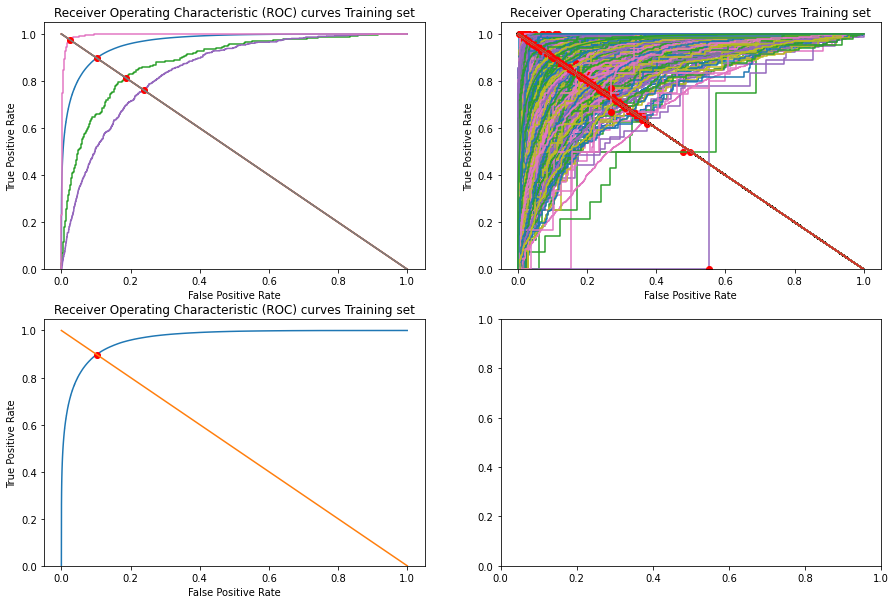

In [77]:
figure, axes = plt.subplots(2, 2, figsize=(15, 10))
metrics.plot_eer_roc(fpr_tfb['micro'], tpr_tfb['micro'], axes[0][0], result_roc_tfb['micro'], "Training set")
metrics.plot_eer_roc(fpr_tfb['micro'], tpr_tfb['micro'], axes[1][0], result_roc_tfb['micro'], "Training set")
metrics.plot_eer_roc(fpr_tfb[0], tpr_tfb[0], axes[0][0], result_roc_tfb[0], "Training set")
metrics.plot_eer_roc(fpr_tfb[1], tpr_tfb[1], axes[0][0], result_roc_tfb[1], "Training set")
metrics.plot_eer_roc(fpr_tfb[2], tpr_tfb[2], axes[0][0], result_roc_tfb[2], "Training set")
for key in result_roc_tfb.keys():
    metrics.plot_eer_roc(fpr_tfb[key], tpr_tfb[key], axes[0][1], result_roc_tfb[key], "Training set")

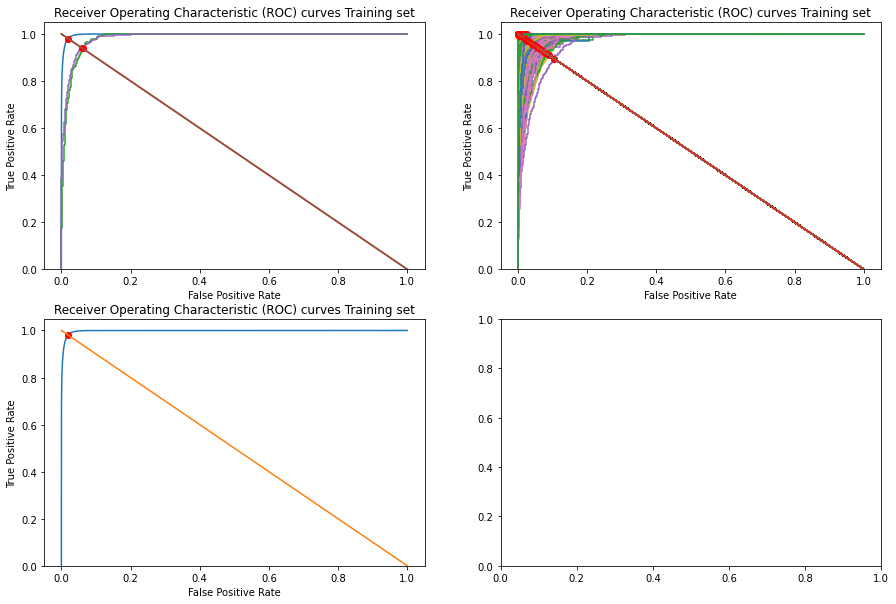

In [78]:
figure, axes = plt.subplots(2, 2, figsize=(15, 10))
metrics.plot_eer_roc(fpr_scb['micro'], tpr_scb['micro'], axes[0][0], result_roc_scb['micro'], "Training set")
metrics.plot_eer_roc(fpr_scb['micro'], tpr_scb['micro'], axes[1][0], result_roc_scb['micro'], "Training set")
metrics.plot_eer_roc(fpr_scb[0], tpr_scb[0], axes[0][0], result_roc_scb[0], "Training set")
metrics.plot_eer_roc(fpr_scb[1], tpr_scb[1], axes[0][0], result_roc_scb[1], "Training set")
# metrics.plot_eer_roc(fpr_scb[2], tpr_scb[2], axes[0][0], result_roc_scb[2], "Training set")
for key in result_roc_scb.keys():
    metrics.plot_eer_roc(fpr_scb[key], tpr_scb[key], axes[0][1], result_roc_scb[key], "Training set")

In [79]:
df_total_scores_tfb = dashboard_model.contruct_auc_scores_by_TF(df_y_tfb, df_score_tfb, ad_tfb, only_TF=only_tf)
df_total_scores_scb = dashboard_model_b.contruct_auc_scores_by_TF(df_y_scb, df_score_scb, ad_scb, only_TF=only_tf)
# df_total_scores_tfb = dashboard_model.contruct_auc_scores_by_TF(df_y_tfb, df_score_tfb, None, only_TF=only_tf)
# df_total_scores_scb = dashboard_model_b.contruct_auc_scores_by_TF(df_y_scb, df_score_scb, None, only_TF=only_tf)
df_total_scores_tfb

auc_roc    auc_pr  count_regions       TF motif_model  \
0    0.882981  0.215565            281    FOXK2    MA1103.2   
1    0.841463  0.238148            684    GATA3    MA0037.3   
2    0.995852  0.932064            645     CTCF    MA0139.1   
3    0.997683  0.968125            775     CTCF    MA0139.1   
4    0.994681  0.926821            863     CTCF    MA0139.1   
..        ...       ...            ...      ...         ...   
940  0.944663  0.283148            131      FOS    MA1134.1   
941  0.781970  0.166930            611     TCF4    MA0830.2   
942  0.857896  0.174922            237      YY1    MA0095.2   
943  0.775305  0.086434            309  BHLHE22    MA0818.1   
944  0.983859  0.195401             70      MYC    MA0147.3   

                                           cell_line  
0                          K562_myelogenous_leukemia  
1                                     Jurkat_T-cells  
2                                        CD4_T-cells  
3      ID00014_lymphoblastoid_cell_DiGeorge_syndrome  
4                                            gm10847  
..                                               ...  
940                   THP-1_acute_monocytic_leukemia  
941            CAL-1_plasmacytoid_dendritic_neoplasm  
942  GM12892_female_B-cells_lymphoblastoid_cell_line  
943            CAL-1_plasmacytoid_dendritic_neoplasm  
944                        MM1_S_plasma_cell_myeloma  

[945 rows x 6 columns]

In [80]:
print('auc roc score : ', df_total_scores_tfb['auc_roc'].mean())
print('auc pr score : ', df_total_scores_tfb['auc_pr'].mean())

auc roc score :  0.9210068226431826
auc pr score :  0.38457707303909056


In [81]:
print('auc roc score : ', df_total_scores_scb['auc_roc'].mean())
print('auc pr score : ', df_total_scores_scb['auc_pr'].mean())

auc roc score :  0.9923806062062371
auc pr score :  0.9063887551608262


In [82]:
hover_data = ['TF', 'count_regions', 'motif_model', df_total_scores_tfb.index]
if motif:
    hover_data.append('cell_line')

fig = px.scatter(df_total_scores_tfb, x="auc_roc", y="auc_pr", hover_data=hover_data, 
                 color="TF", marginal_x=rug, marginal_y=rug)
fig.show()

In [83]:
hover_data = ['TF', 'count_regions', 'motif_model', df_total_scores_scb.index]
if motif:
    hover_data.append('cell_line')

fig = px.scatter(df_total_scores_scb, x="auc_roc", y="auc_pr", hover_data=hover_data, 
                 color="TF", marginal_x=rug, marginal_y=rug)
fig.show()

In [84]:
df_roc_pr = pd.DataFrame()
df_roc_pr['auc_pr_tfb'] = df_total_scores_tfb['auc_pr']
df_roc_pr['auc_roc_tfb'] = df_total_scores_tfb['auc_roc']
df_roc_pr['auc_pr_tfb_TL'] = df_total_scores_scb['auc_pr']
df_roc_pr['auc_roc_tfb_TL'] = df_total_scores_scb['auc_roc']
df_roc_pr['count_regions'] = df_total_scores_scb['count_regions']
df_roc_pr['TF'] = df_total_scores_tfb['TF']

In [85]:
fig = px.scatter(df_roc_pr, x="auc_roc_tfb", y="auc_roc_tfb_TL", hover_data=['TF', 'count_regions'], 
                 color="TF", marginal_x=rug, marginal_y=rug)
fig.add_shape(type="line",
              x0=0, 
              y0=0, 
              x1=1, 
              y1=1)
fig.show()

In [86]:
fig = px.scatter(df_roc_pr, x="auc_pr_tfb", y="auc_pr_tfb_TL", hover_data=['TF', 'count_regions'], 
                 color="TF", marginal_x=rug, marginal_y=rug)
fig.add_shape(type="line",
              x0=0, 
              y0=0, 
              x1=1, 
              y1=1)
fig.show()

#### validation and test

In [87]:
df_val_score_tfb, df_val_y_tfb = dashboard_model.predict_batch(dashboard_model.test_dataloader, sigmoid=True)
df_val_score_scb, df_val_y_scb = dashboard_model_b.predict_batch(dashboard_model_b.test_dataloader, sigmoid=True)

fpr_tfb, tpr_tfb, fnr_tfb, opt_threshold_tfb, threshold_tfb, roc_auc_tfb, result_roc_tfb = metrics.roc_curve_multilabel(df_val_score_tfb, df_val_y_tfb)
fpr_scb, tpr_scb, fnr_scb, opt_threshold_scb, threshold_scb, roc_auc_scb, result_roc_scb = metrics.roc_curve_multilabel(df_val_score_scb, df_val_y_scb)
print(opt_threshold_tfb['micro'])

sum = 0
for key in opt_threshold_tfb.keys():
    if key != 'micro':
        sum += opt_threshold_tfb[key]
sum / (len(opt_threshold_tfb.keys()) - 1)

100%|█████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 63.06batch/s]
/staging/leuven/stg_00002/lcb/hsnyers/software/anaconda3/envs/tfbanformer/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless

/staging/leuven/stg_00002/lcb/hsnyers/software/anaconda3/envs/tfbanformer/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless

/staging/leuven/stg_00002/lcb/hsnyers/software/anaconda3/envs/tfbanformer/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless

/staging/leuven/stg_00002/lcb/hsnyers/software/anaconda3/envs/tfbanformer/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning:

No positive samples 

0.012752648


0.01596194674946134

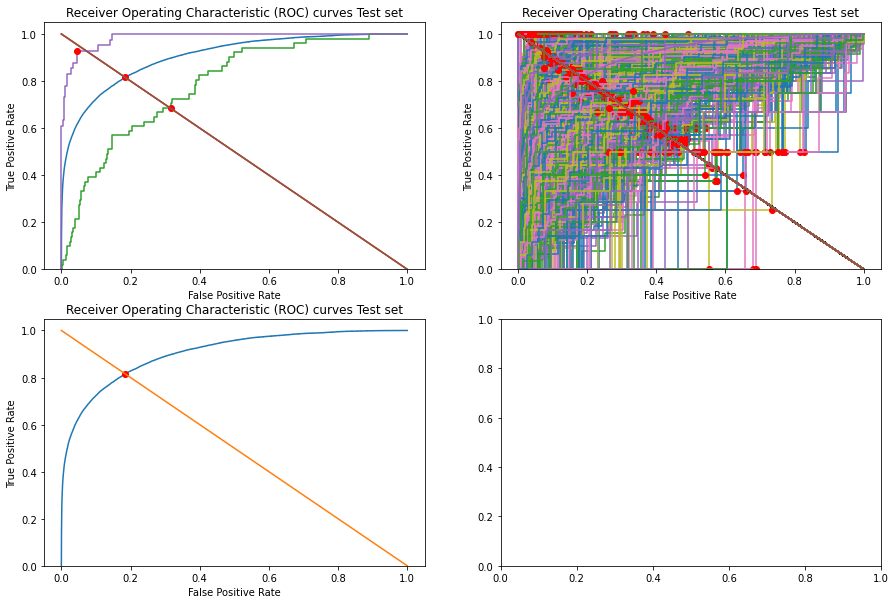

In [88]:
figure, axes = plt.subplots(2, 2, figsize=(15, 10))
metrics.plot_eer_roc(fpr_tfb['micro'], tpr_tfb['micro'], axes[0][0], result_roc_tfb['micro'], "Test set")
metrics.plot_eer_roc(fpr_tfb['micro'], tpr_tfb['micro'], axes[1][0], result_roc_tfb['micro'], "Test set")
# metrics.plot_eer_roc(fpr_tfb[0], tpr_tfb[0], axes[0][0], result_roc_tfb[0], "Test set")
metrics.plot_eer_roc(fpr_tfb[1], tpr_tfb[1], axes[0][0], result_roc_tfb[1], "Test set")
metrics.plot_eer_roc(fpr_tfb[2], tpr_tfb[2], axes[0][0], result_roc_tfb[2], "Test set")
for key in result_roc_tfb.keys():
    metrics.plot_eer_roc(fpr_tfb[key], tpr_tfb[key], axes[0][1], result_roc_tfb[key], "Test set")

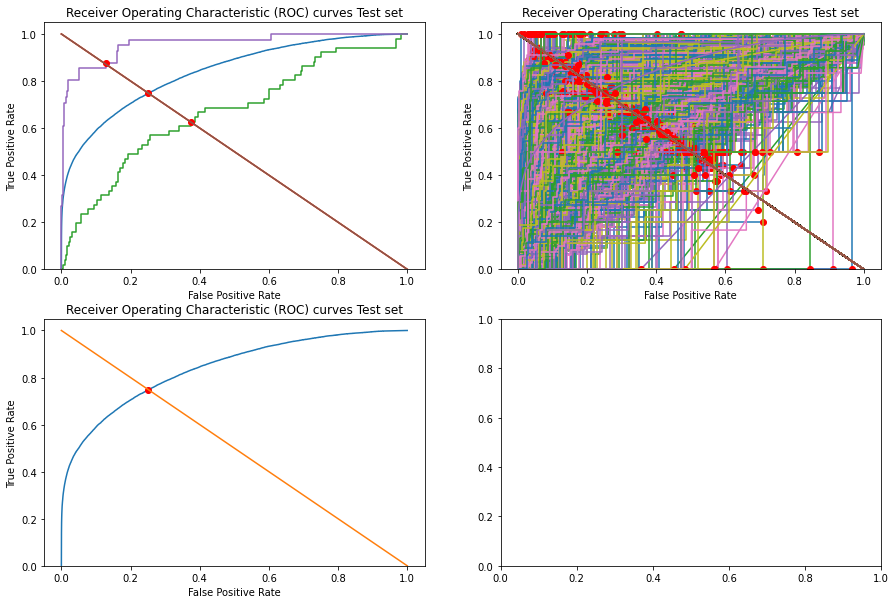

In [89]:
figure, axes = plt.subplots(2, 2, figsize=(15, 10))
metrics.plot_eer_roc(fpr_scb['micro'], tpr_scb['micro'], axes[0][0], result_roc_scb['micro'], "Test set")
metrics.plot_eer_roc(fpr_scb['micro'], tpr_scb['micro'], axes[1][0], result_roc_scb['micro'], "Test set")
# metrics.plot_eer_roc(fpr_scb[0], tpr_scb[0], axes[0][0], result_roc_scb[0], "Test set")
metrics.plot_eer_roc(fpr_scb[1], tpr_scb[1], axes[0][0], result_roc_scb[1], "Test set")
metrics.plot_eer_roc(fpr_scb[2], tpr_scb[2], axes[0][0], result_roc_scb[2], "Test set")
for key in result_roc_scb.keys():
    metrics.plot_eer_roc(fpr_scb[key], tpr_scb[key], axes[0][1], result_roc_scb[key], "Test set")

In [90]:
df_val_scores_tfb = dashboard_model.contruct_auc_scores_by_TF(df_val_y_tfb, df_val_score_tfb, ad_tfb, only_TF=only_tf)
df_val_scores_scb = dashboard_model_b.contruct_auc_scores_by_TF(df_val_y_scb, df_val_score_scb, ad_scb, only_TF=only_tf)

In [91]:
print(st.norm.interval(alpha=0.99, loc=np.mean(df_val_scores_tfb['auc_pr']), scale=st.sem(df_val_scores_tfb['auc_pr'])))
percentile = 99
low_99 = round(len(df_val_scores_tfb[df_val_scores_tfb['count_regions'] > 0])*(100-percentile)/2/100)
up_99 = round(len(df_val_scores_tfb[df_val_scores_tfb['count_regions'] > 0])*(percentile + (100-percentile)/2)/100)
print('auc roc score : ', df_val_scores_tfb[df_val_scores_tfb['count_regions'] > 0]['auc_roc'][low_99:up_99+1].mean())
print('auc pr score : ', df_val_scores_tfb[df_val_scores_tfb['count_regions'] > 0]['auc_pr'][low_99:up_99+1].mean())

print(st.norm.interval(alpha=0.99, loc=np.mean(df_val_scores_scb['auc_pr']), scale=st.sem(df_val_scores_scb['auc_pr'])))
percentile = 99
low_99 = round(len(df_val_scores_scb[df_val_scores_scb['count_regions'] > 0])*(100-percentile)/2/100)
up_99 = round(len(df_val_scores_scb[df_val_scores_scb['count_regions'] > 0])*(percentile + (100-percentile)/2)/100)
print('auc roc score : ', df_val_scores_scb[df_val_scores_scb['count_regions'] > 0]['auc_roc'][low_99:up_99+1].mean())
print('auc pr score : ', df_val_scores_scb[df_val_scores_scb['count_regions'] > 0]['auc_pr'][low_99:up_99+1].mean())

(0.26889359486033265, 0.3198886312395253)
auc roc score :  0.8063328376591372
auc pr score :  0.31345224872795424
(0.20135591283099125, 0.24900685673083456)
auc roc score :  0.7336204369836234
auc pr score :  0.23902076817165882


In [92]:
hover_data = ['TF', 'count_regions', 'motif_model', df_val_scores_tfb.index]
if motif:
    hover_data.append('cell_line')

fig = px.scatter(df_val_scores_tfb, x="auc_roc", y="auc_pr", hover_data=hover_data, 
                 color="TF", marginal_x=rug, marginal_y=rug)
fig.show()

In [93]:
hover_data = ['TF', 'count_regions', 'motif_model', df_val_scores_scb.index]
if motif:
    hover_data.append('cell_line')

fig = px.scatter(df_val_scores_scb, x="auc_roc", y="auc_pr", hover_data=hover_data, 
                 color="TF", marginal_x=rug, marginal_y=rug)
fig.show()

In [94]:
df_val_roc_pr = pd.DataFrame()
df_val_roc_pr['auc_pr_tfb'] = df_val_scores_tfb['auc_pr']
df_val_roc_pr['auc_roc_tfb'] = df_val_scores_tfb['auc_roc']
df_val_roc_pr['auc_pr_tfb_TL'] = df_val_scores_scb['auc_pr']
df_val_roc_pr['auc_roc_tfb_TL'] = df_val_scores_scb['auc_roc']
df_val_roc_pr['count_regions'] = df_val_scores_scb['count_regions']
df_val_roc_pr['TF'] = df_val_scores_tfb['TF']

In [95]:
fig = px.scatter(df_val_roc_pr, x="auc_roc_tfb", y="auc_roc_tfb_TL", hover_data=['TF', 'count_regions'], 
                 color="TF", marginal_x=rug, marginal_y=rug, color_discrete_sequence=px.colors.qualitative.Dark24)
fig.add_shape(type="line",
              x0=0, 
              y0=0, 
              x1=1, 
              y1=1)
fig.show()

In [96]:
fig = px.scatter(df_val_roc_pr, x="auc_pr_tfb", y="auc_pr_tfb_TL", hover_data=['TF', 'count_regions'], 
                 color="TF", marginal_x=rug, marginal_y=rug, color_discrete_sequence=px.colors.qualitative.Dark24)
fig.add_shape(type="line",
              x0=0, 
              y0=0, 
              x1=1, 
              y1=1)
fig.show()

In [97]:
selection = ['CTCF', 'SPI1', 'MYC', 'RUNX1', 'RXRA', 'YY1', 'RELA', 'FOS', 'CEBPA', 'CEBPB', 'JUN', 'GATA2', 'JUND', 'REST', 'GATA3', 'TP53', 'MAX', 'GABPA', 'PAX5', 'EBF1']

df2 = df_val_roc_pr[df_val_roc_pr.TF.apply(lambda x: np.any(np.in1d(x, selection)))]
# df2.TF.cat.remove_unused_categories(inplace=True)
df2.TF.head(5)

1    GATA3
2     CTCF
3     CTCF
4     CTCF
5     CTCF
Name: TF, dtype: category
Categories (144, object): ['ARNT', 'ATF2', 'ATF3', 'ATF4', ..., 'YY1', 'ZFX', 'ZNF143', 'ZNF740']

In [98]:
import plotly.express as px
fig = px.scatter(df2, x="auc_roc_tfb", y="auc_roc_tfb_TL", hover_data=['TF', 'count_regions'], width=900, height=550, 
                 color="TF", marginal_x=rug, marginal_y=rug, color_discrete_sequence=px.colors.qualitative.Dark24)
fig.add_shape(type="line",
              x0=0, 
              y0=0, 
              x1=1, 
              y1=1)
fig.show()

KeyError: 'ARNT'

In [ ]:
import plotly.express as px

fig = px.scatter(df2, x="auc_pr_tfb", y="auc_pr_tfb_TL", hover_data=['TF', 'count_regions'], width=900, height=550, 
                 color="TF", marginal_x=rug, marginal_y=rug, color_discrete_sequence=px.colors.qualitative.Dark24)
fig.add_shape(type="line",
              x0=0, 
              y0=0, 
              x1=1, 
              y1=1)
fig.show()

In [ ]:
df1 = df_val_scores_tfb[df_val_scores_tfb.TF.apply(lambda x: np.any(np.in1d(x, selection)))]
# df1.TF.cat.remove_unused_categories(inplace=True)
df1.TF.head(5)

hover_data = ['TF', 'count_regions', 'motif_model', df1.index]
if motif:
    hover_data.append('cell_line')

fig = px.scatter(df1, x="auc_roc", y="auc_pr", hover_data=hover_data, 
                 color="TF", marginal_x=rug, marginal_y=rug, width=900, height=550)
fig.show()